          host_name                  hash                 diff
0   d-03.winudf.com    239767381301946287   239767381301946287
1   d-02.winudf.com    452996756677201714   213229375375255427
2   d-01.winudf.com    784583097262749752   331586340585548038
3   d-01.winudf.com   2977716204983640882  2193133107720891130
4   d-05.winudf.com   3056735848870237707    79019643886596825
5   d-02.winudf.com   3502165566924052056   445429718053814349
6   d-05.winudf.com   3696353760717863724   194188193793811668
7   d-03.winudf.com   3983909878270734083   287556117552870359
8   d-01.winudf.com   4218835131624438454   234925253353704371
9   d-04.winudf.com   4451133326594493219   232298194970054765
10  d-04.winudf.com   4904457498958676496   453324172364183277
11  d-05.winudf.com   5070389339984637017   165931841025960521
12  d-04.winudf.com   5193981502517103491   123592162532466474
13  d-05.winudf.com   5528192315630124532   334210813113021041
14  d-01.winudf.com   6666967547630157160  113877523200

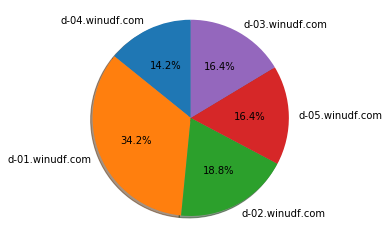

In [ ]:
%run consistance_balance.py

#### 1.hash的不均衡分布

看图发现，d-01的百分比远高于其他. 使用一致性算法，d-01主机的带宽负载较高，需要均衡到其他主机.



#### 2.平衡算法
[一致性hash负载平衡](https://research.googleblog.com/2017/04/consistent-hashing-with-bounded-loads.html)
[中文](https://www.leiphone.com/news/201704/xRiQjGMRKnJaXuOe.html)
[go实现](https://github.com/lafikl/consistent)

```go
// It uses Consistent Hashing With Bounded loads
//
// https://research.googleblog.com/2017/04/consistent-hashing-with-bounded-loads.html
//
// to pick the least loaded host that can serve the key
//
// It returns ErrNoHosts if the ring has no hosts in it.
//
func (c *Consistent) GetLeast(key string) (string, error) {
	c.RLock()
	defer c.RUnlock()

	if len(c.hosts) == 0 {
		return "", ErrNoHosts
	}

	h := c.hash(key)
	idx := c.search(h)
	fmt.Println("hash:%v idx:%v", h, idx)

	i := idx
	for {
		host := c.hosts[c.sortedSet[i]]
		fmt.Println("host:", host, "i:", i)
		c.print()
		if c.loadOK(host) {
			return host, nil
		}
		i++
		if i >= len(c.hosts) {
			i = 0
		}
	}
}


func (c *Consistent) loadOK(host string) bool {
	// a safety check if someone performed c.Done more than needed
	if c.totalLoad < 0 {
		c.totalLoad = 0
	}

	var avgLoadPerNode float64
	avgLoadPerNode = float64((c.totalLoad + 1) / int64(len(c.loadMap))) // 总负载／(5台主机)
	fmt.Println("avgLoadPerNode:", avgLoadPerNode, "c.totalLoad + 1:", c.totalLoad + 1, "loadMap:", len(c.loadMap))
	if avgLoadPerNode == 0 {
		avgLoadPerNode = 1
	}
	avgLoadPerNode = math.Ceil(avgLoadPerNode * 1.25) //乘1.25倍， 向上取整
	fmt.Println("*1.25:", avgLoadPerNode)
	bhost, ok := c.loadMap[host]
	if !ok {
		panic(fmt.Sprintf("given host(%s) not in loadsMap", bhost.Name))
	}

	if float64(bhost.Load)+1 <= avgLoadPerNode {
		return true
	}

	return false
}
```

#### 3. 均衡思想

同一个key 的10次请求，host: d-01/5

1. 一致性计算在d-01. load[d-01] <= Maxload, 返回d-01， load[d-01]为1， maxload为2
2. 一致性计算在d-01. load[d-01] <= Maxload, 返回d-01,  load[d-01]为2, maxload为2
3. 一致性计算在d-01. load[d-01] <= Maxload, False,
     load[d-02] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-02.
    
4. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (3 + 1)/5 * 1.25 ==> 0 * 1.25 ==> 1 * 1.25
    load[d-02] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-02.  
    
5. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (4 + 1)/5 * 1.25 ==> 1 * 1.25
    load[d-02] <= Maxload, False
    load[d-03] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-03.
    
6. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (5 + 1)/5 * 1.25 
    load[d-02] <= Maxload, False
    load[d-03] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-03.
    
7. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (6 + 1)/5 * 1.25 
    load[d-02] <= Maxload, False
    load[d-03] <= Maxload, False
    load[d-04] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-04.
    
8. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (7 + 1)/5 * 1.25 
    load[d-02] <= Maxload, False
    load[d-03] <= Maxload, False
    load[d-04] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-04.
    
    
9. 一致性计算在d-01. load[d-01] <= Maxload, False, MaxLoad 2. (8 + 1)/5 * 1.25 
    load[d-02] <= Maxload, False
    load[d-03] <= Maxload, False
    load[d-04] <= Maxload, False
    load[d-05] <= Maxload, True
    返回第一个负载满足要求的host. 返回d-05.
    
10. 一致性计算在d-01. load[d-01] <= Maxload, True, MaxLoad 由2变为3. (9 + 1)/5 * 1.25 ==> 2 * 1.25
    返回第一个负载满足要求的host. 返回d-01.